# Introduction
State notebook purpose here

### Get source folder and append to sys directory

In [1]:
from __future__ import print_function
import os
import sys
PROJ_ROOT = os.path.join(os.pardir)
print(os.path.abspath(PROJ_ROOT))
src_dir = os.path.join(PROJ_ROOT, "src")
sys.path.append(src_dir)
# Data path example
#pump_data_path = os.path.join(PROJ_ROOT,
#                              "data",
#                              "raw",
#                              "pumps_train_values.csv")

/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/runnable_program


### Imports
Import libraries and write settings here.

In [60]:
# Data manipulation
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
from sklearn.cluster import KMeans
import glob

from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30
# Display all cell outputs
InteractiveShell.ast_node_interactivity = 'all'
ipython = get_ipython()
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 1
# Use %aimport module to reload each module

# Custom import
%aimport data.create_load_transform_processed_data
from data import create_load_transform_processed_data

/home/nam/Development/anaconda3/lib/python3.8/site-packages/tslearn/clustering/kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


# Analysis/Modeling
Do work here

In [161]:
# """
# Now what we should do is explore data for clustering.
# First read data. This data is processed data which only have site, date and PM25 values
# Each site's data will be an element in site_data_series
# Remove site 48 and 49
# 2 WCSS
# 3 pair plot data????
# """
interim_data_path = os.path.join(PROJ_ROOT,
                                   "data",
                                   "interim")
site_data_files = glob.glob(interim_data_path+"/*.csv")
site_data_series = []
trouble_series = []
for file in site_data_files:
    tmp_series = pd.read_csv(file, index_col=['site_id','time'], parse_dates=True)
    if tmp_series.index.get_level_values(0)[0] not in [48,49,16,15]:
        tmp_series = tmp_series[['PM25']]
#         Replace 0 with median
        tmp_series['PM25'] = tmp_series['PM25'].replace(0, np.nanmedian(tmp_series['PM25'].values))
#         Replace null with medin
        tmp_series['PM25'] = tmp_series['PM25'].fillna(value=np.nanmedian(tmp_series['PM25'].values))
        site_data_series.append(tmp_series)

In [162]:
# How many series we have
print(len(site_data_series))

33


In [163]:
# There must be 3611 data points in each sites, check if this is true
# Check number of item in each sites
def check_missing_index(site_data_series):
    for element in range(0,len(site_data_series)):
        if len(site_data_series[element]) != 3611:
            print("{} different".format(site_data_series[element].index.get_level_values(0)[0]))
check_missing_index(site_data_series)

40 different
14 different


Proceed to fill in missing data

In [164]:
def fill_missing_date(df):
    full_hour_index = pd.date_range(df.index.get_level_values(1).min(),
                    df.index.get_level_values(1).max(),
                    freq="1H")
    idx = list(zip([df.index.get_level_values(0)[0]]*len(full_hour_index),
                   full_hour_index))
    df = df.reindex(idx, fill_value=np.nanmedian(df.values))
    return df

for element in range(0,len(site_data_series)):
    if len(site_data_series[element]) != 3611:
        site_data_series[element] = fill_missing_date(site_data_series[element])

In [166]:
# Check missing index again
check_missing_index(site_data_series)

So all index are fully filled

In [167]:
# We change data from series to list for easy edit
site_data_list = []
site_data_list_name = []
for element in site_data_series:
    site_data_list.append(element.values.ravel())
    site_data_list_name.append("Site {}".format(element.index.get_level_values(0)[0]))

In [ ]:
# Get all data to the same range
for i in range(len(site_data_list)):
    scaler = MinMaxScaler()
    site_data_list[i] = MinMaxScaler().fit_transform(site_data_list[i])
    site_data_list[i]= site_data_list[i].reshape(len(site_data_list[i]))

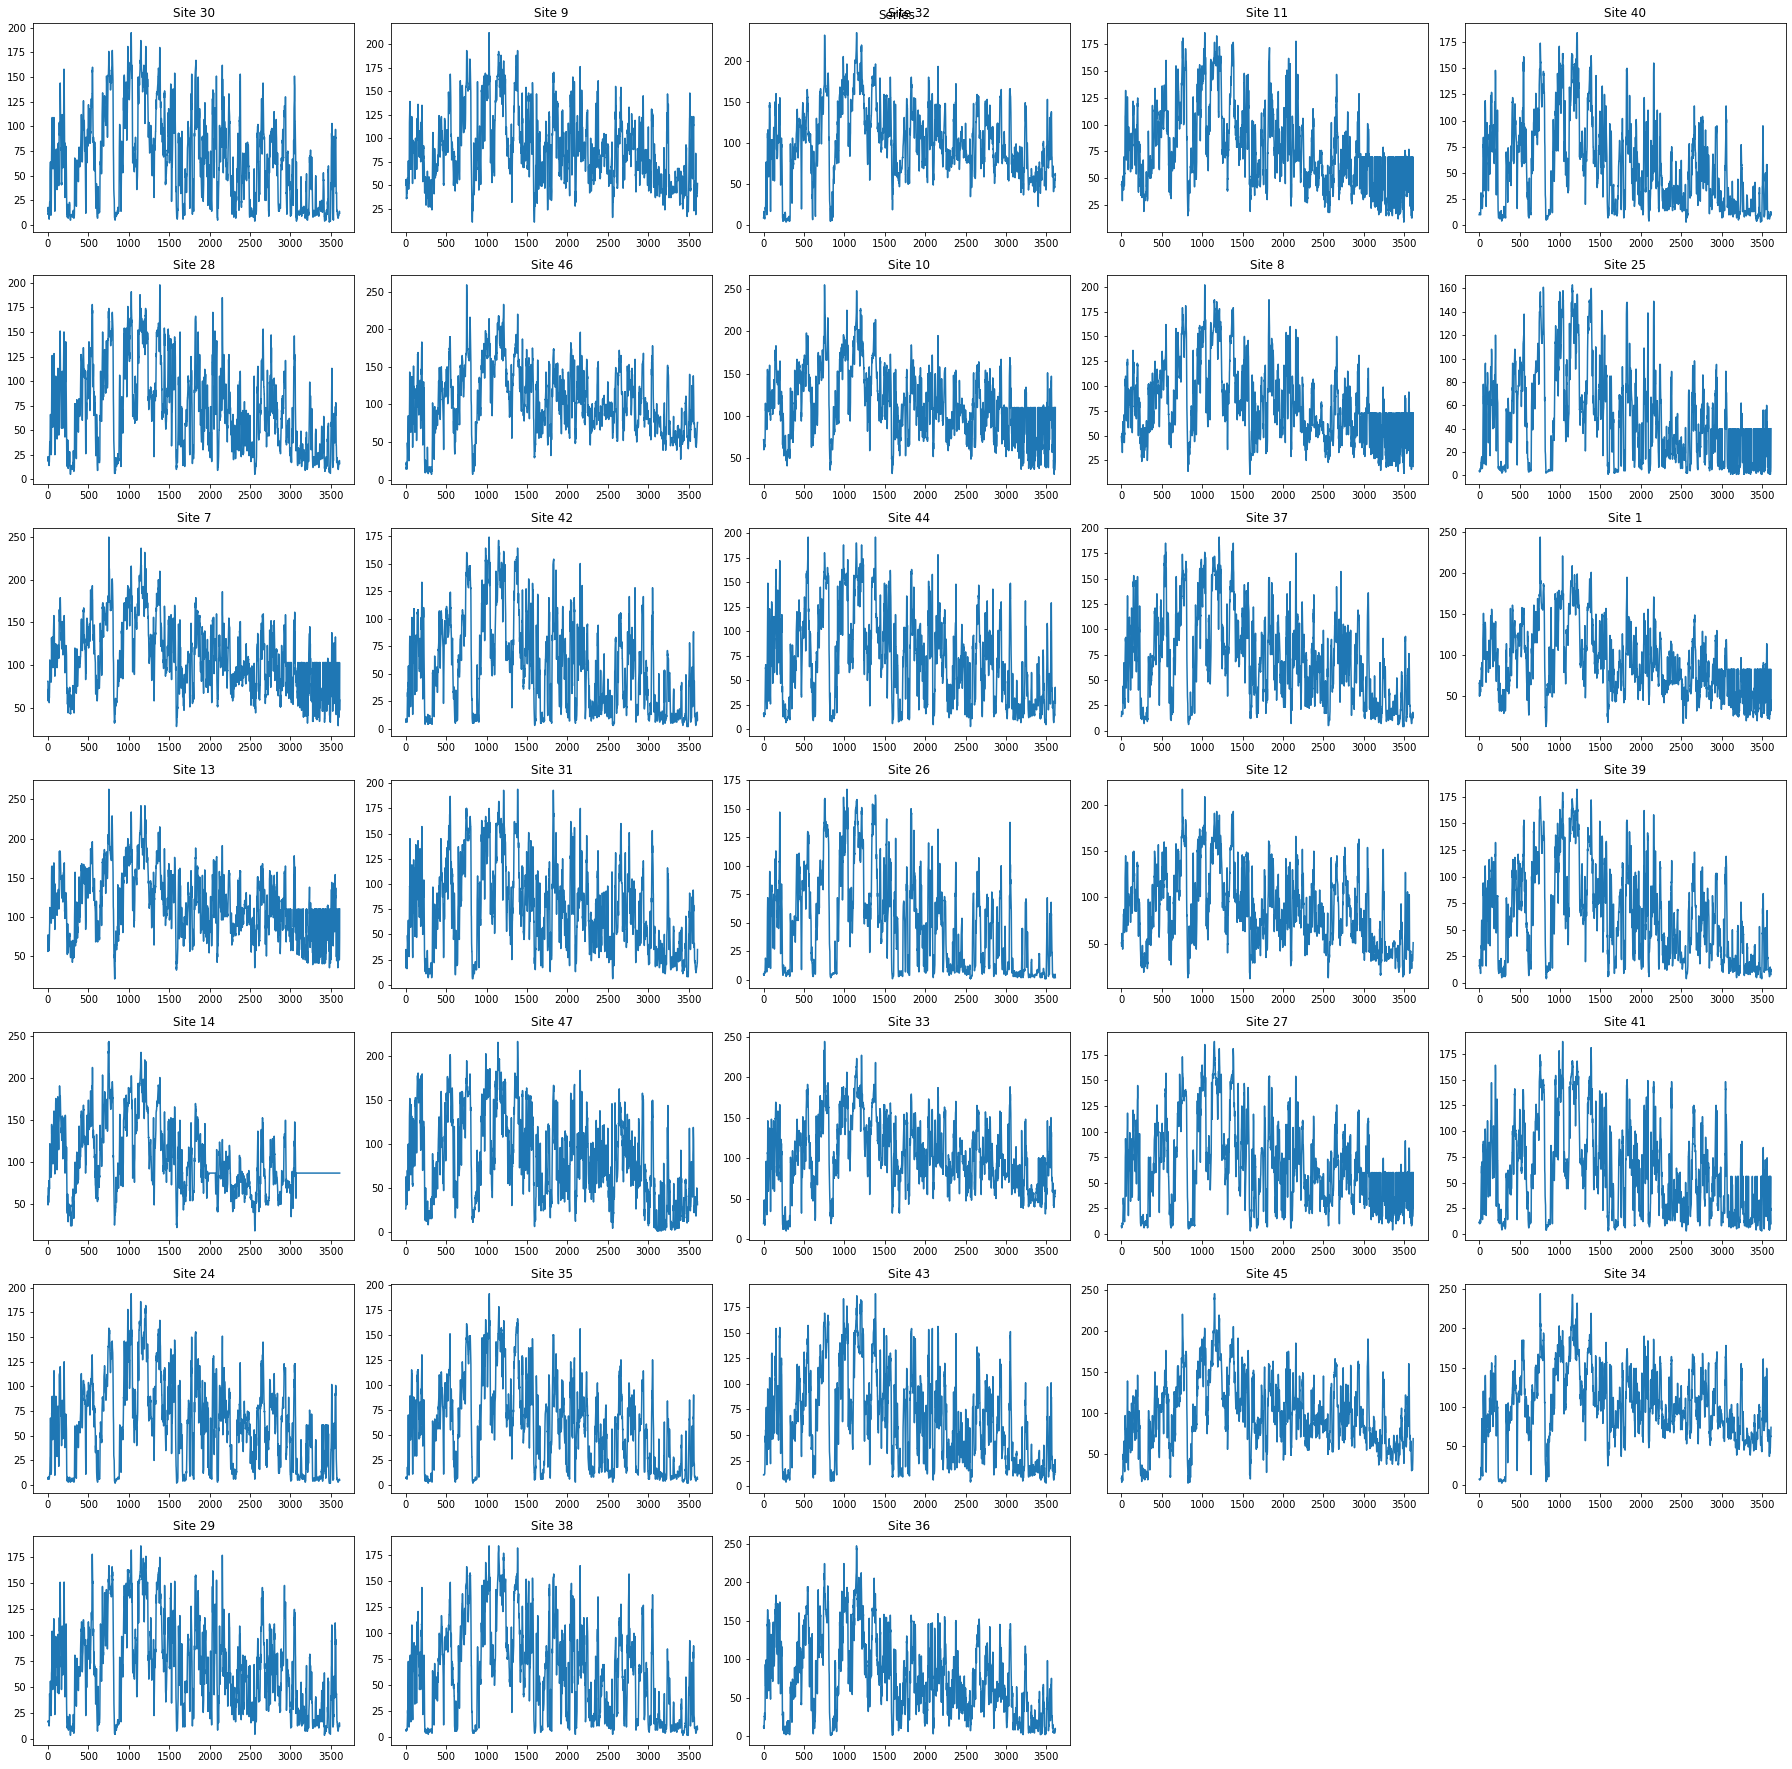

In [168]:
def plot_all_data_as_series(array, num_col=5, num_row=None):
    """
    This function accept an array of series and an array of each serie's name
    :param array: list
    """
    fig = plt.figure(figsize=(25,25))
    fig.suptitle('Series')
    if num_row==None:
        num_row = (len(array) // num_col) + 1
        
    gs = fig.add_gridspec(num_row, num_col)
    axes = []
    try:
        for row in range(num_row):
            for col in range(num_col):
                if type(array[row * num_col + col]) is pd.core.frame.DataFrame:
                    axes.append(fig.add_subplot(gs[row, col]))
                    axes[row * num_col + col].plot(array[row * num_col + col].values)
                    axes[row * num_col + col].set_title("Site {}".format(array[row * num_col + col].index.get_level_values(0)[0]))
                else:
                    print("This is not a dataframe {}".format(array[row * num_col + col]))
#                     axes.append(fig.add_subplot(gs[row, col]))
#                     axes[row * 6 + col].plot(array[row * 6 + col])
#                     axes[row * 6 + col].set_title(array[row * 6 + col][0])
    except IndexError:
        pass
    plt.tight_layout()
    plt.show()

plot_all_data_as_series(site_data_series)

Just by looking, we have seen that there is definitely some pattern between each site. Next we use KMean to find the clusters and visualize those for more information.

In [169]:
# Use time series KMean
model = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=10)
model.fit(site_data_list)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=5)

# Results
Show graphs and stats here

In [170]:
labels = model.predict(site_data_list)

/home/nam/Development/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 33 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


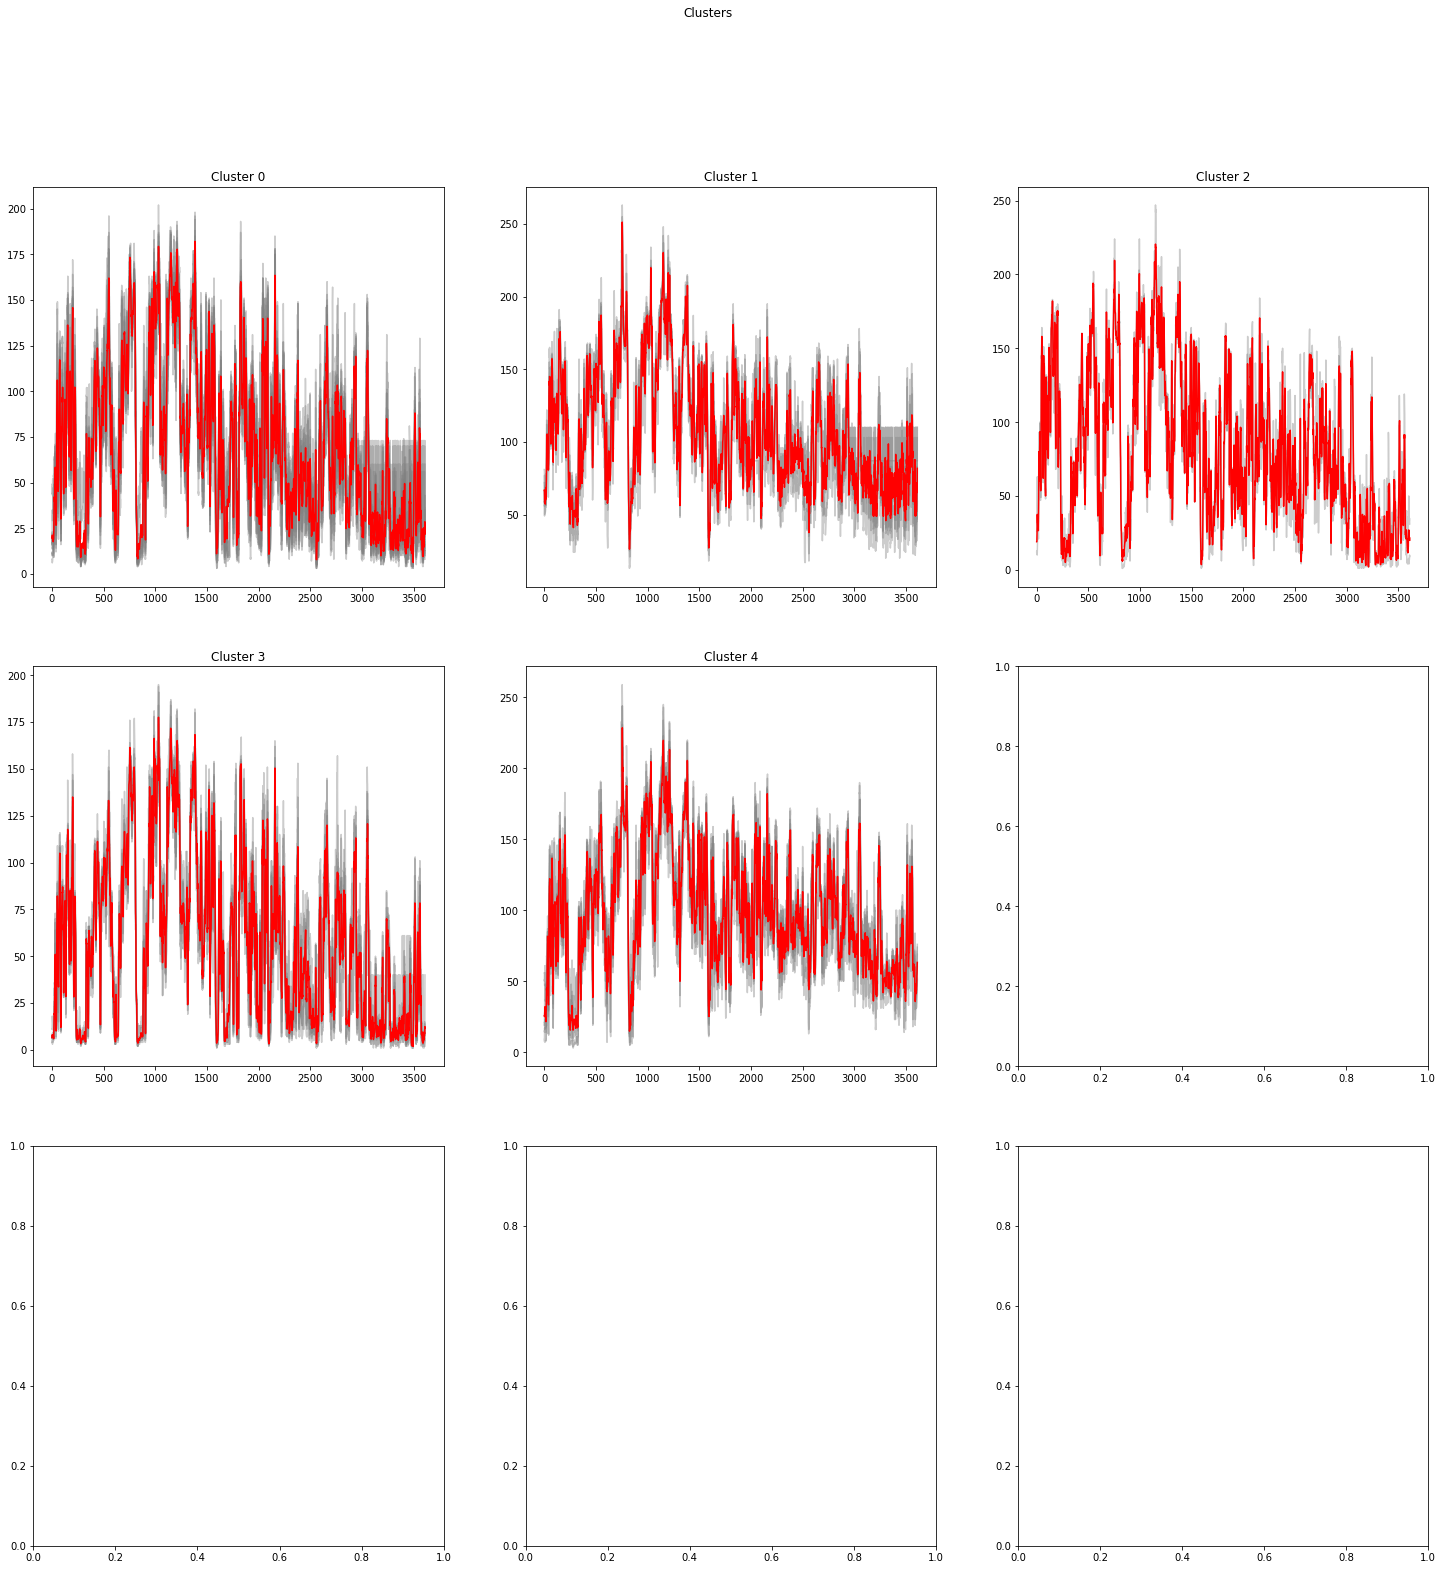

In [174]:
def plot_result(mySeries, labels):
    fig, axs = plt.subplots(3,3,figsize=(25,25))
    fig.suptitle('Clusters')
    row_i=0
    column_j=0
    # For each label there is,
    # plots every series with that label
    for label in set(labels):
        cluster = []
        for i in range(len(labels)):
                if(labels[i]==label):
                    axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                    cluster.append(mySeries[i])
        if len(cluster) > 0:
            axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
        axs[row_i, column_j].set_title("Cluster "+str(row_i*3+column_j))
        column_j+=1
        if column_j%3 == 0:
            row_i+=1
            column_j=0
    plt.show()
plot_result(site_data_list, labels)

We can see that the data of cluster 2 and 3 are somewhat similar. We can use this information to choose a better parameter: metrics or number of cluster.

# Conclusions and Next Steps
Summarize findings here